In [1]:
import warnings
from pathlib import Path
import os
import pandas as pd
import tqdm
import random
import pickle

import socceraction.spadl as spadl
import socceraction.atomic.spadl as atomicspadl
import socceraction.atomic.vaep.features as fs
import socceraction.atomic.vaep.labels as lab
import socceraction.atomic.vaep.formula as vaepformula
from socceraction.spadl.wyscout import convert_to_actions
from socceraction.data.wyscout import PublicWyscoutLoader

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression as logistic
from sklearn.ensemble import RandomForestClassifier as rfc
from catboost import CatBoostClassifier 
from xgboost import XGBClassifier as XGBc
from sklearn.metrics import brier_score_loss, roc_auc_score, log_loss

# Preprocessing

In [2]:
wyscout = PublicWyscoutLoader(root = '/Users/leonardoyang/Desktop/Tesi/Wyscout/raw/data', download=False)

In [3]:
competitions = wyscout.competitions()
competitions.info()

<class 'pandera.typing.pandas.DataFrame'>
RangeIndex: 7 entries, 0 to 6
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   competition_id      7 non-null      int64 
 1   season_id           7 non-null      int64 
 2   country_name        7 non-null      object
 3   competition_name    7 non-null      object
 4   competition_gender  7 non-null      object
 5   season_name         7 non-null      object
dtypes: int64(2), object(4)
memory usage: 464.0+ bytes


In [4]:
comp = ['Spain']
selected_competitions = competitions[(competitions['country_name'] =='Spain')]
selected_competitions

,competition_id,season_id,country_name,competition_name,competition_gender,season_name
2,795,181144,Spain,Spanish first division,male,2017/2018


### Retrieve the scoreline of a game

In [5]:
dfs_matches = []
#Retrieve matches of a selected competition
for competition in comp:
    competition_name = competition
    file_matches = f'matches_{competition_name}.json'
    df_matches = pd.read_json('/Users/leonardoyang/Desktop/Tesi/Wyscout/raw/Data/' + file_matches)
    dfs_matches.append(df_matches)
    
#Create a unique dataframe containing all the selected games
df_matches = pd.concat(dfs_matches)
df_matches.reset_index(drop = True, inplace = True)
df_matches.head(1)

,status,roundId,gameweek,teamsData,seasonId,dateutc,winner,venue,wyId,label,date,referees,duration,competitionId
0,Played,4406122,38,"{'676': {'scoreET': 0, 'coachId': 92894, 'side...",181144,2018-05-20 18:45:00,676,Camp Nou,2565922,"Barcelona - Real Sociedad, 1 - 0","May 20, 2018 at 8:45:00 PM GMT+2","[{'refereeId': 398931, 'role': 'referee'}, {'r...",Regular,795


In [6]:
#Extrapolate the scoreline of the game 
home_score, away_score = [],[]
for i in range(len(df_matches)) : 
    home_id, away_id = df_matches['teamsData'][i].keys()
    if df_matches['teamsData'][i][home_id]['side'] == 'away':
        home_id, away_id = away_id, home_id
    if df_matches['duration'][i] !='Regular':
        home_score.append(df_matches['teamsData'][i][home_id]['scoreET'])
        away_score.append(df_matches['teamsData'][i][away_id]['scoreET'])
    else:    
        home_score.append(df_matches['teamsData'][i][home_id]['score']+df_matches['teamsData'][i][home_id]['scoreET'])
        away_score.append(df_matches['teamsData'][i][away_id]['score']+df_matches['teamsData'][i][away_id]['scoreET'])

df_matches['home_score'] = home_score
df_matches['away_score'] = away_score
df_matches = df_matches[['seasonId','wyId','label','competitionId', 'home_score','away_score']]
df_matches.rename(columns={'seasonId':'season_id', 'wyId':'game_id','competitionId':'competition_id'}, inplace = True)

df_matches.head()

,season_id,game_id,label,competition_id,home_score,away_score
0,181144,2565922,"Barcelona - Real Sociedad, 1 - 0",795,1,0
1,181144,2565925,"Atl\u00e9tico Madrid - Eibar, 2 - 2",795,2,2
2,181144,2565919,"Athletic Club - Espanyol, 0 - 1",795,0,1
3,181144,2565924,"Valencia - Deportivo La Coru\u00f1a, 2 - 1",795,2,1
4,181144,2565927,"Villarreal - Real Madrid, 2 - 2",795,2,2


In [7]:
# Get games  with goals from all selected competitions
games = pd.concat([wyscout.games(row.competition_id, row.season_id) for row in selected_competitions.itertuples()])

match_goals = pd.merge(games, df_matches, on =['game_id','competition_id','season_id'])
match_goals.drop(['label'],axis = 1, inplace = True)
games = match_goals

games.head()

,game_id,competition_id,season_id,game_date,game_day,home_team_id,away_team_id,home_score,away_score
0,2565922,795,181144,2018-05-20 18:45:00,38,676,687,1,0
1,2565925,795,181144,2018-05-20 16:30:00,38,679,701,2,2
2,2565919,795,181144,2018-05-20 14:15:00,38,678,691,0,1
3,2565924,795,181144,2018-05-20 10:00:00,38,674,677,2,1
4,2565927,795,181144,2018-05-19 18:45:00,38,682,675,2,2


In [8]:
games.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 380 entries, 0 to 379
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   game_id         380 non-null    int64         
 1   competition_id  380 non-null    int64         
 2   season_id       380 non-null    int64         
 3   game_date       380 non-null    datetime64[ns]
 4   game_day        380 non-null    int64         
 5   home_team_id    380 non-null    int64         
 6   away_team_id    380 non-null    int64         
 7   home_score      380 non-null    int64         
 8   away_score      380 non-null    int64         
dtypes: datetime64[ns](1), int64(8)
memory usage: 29.7 KB


# SPADL

In [9]:
#Store everything in the HDF
datafolder = "/Users/leonardoyang/Desktop/data-fifa/Spa"

In [10]:
#To upload the DF
spadl_h5 = os.path.join(datafolder, "atomic_spadl-wyscout.h5")

In [11]:
pd.HDFStore(spadl_h5)['teams'].reset_index().drop('index', axis =1)

,team_id,team_name_short,team_name
0,676,Barcelona,FC Barcelona
1,687,Real Sociedad,Real Sociedad de F\u00fatbol
2,679,Atl\u00e9tico Madrid,Club Atl\u00e9tico de Madrid
3,701,Eibar,SD Eibar
4,691,Espanyol,Reial Club Deportiu Espanyol
5,678,Athletic Club,Athletic Club Bilbao
6,674,Valencia,Valencia Club de F\u00fatbol
7,677,Deportivo La Coru\u00f1a,Real Club Deportivo de La Coru\u00f1a
8,675,Real Madrid,Real Madrid Club de F\u00fatbol
9,682,Villarreal,Villarreal Club de F\u00fatbol


In [12]:
#Select a game
with pd.HDFStore(spadl_h5) as spadlstore:
    games = (
        spadlstore["games"]
        .merge(spadlstore["competitions"], how='left')
        .merge(spadlstore["teams"].add_prefix('home_'), how='left')
        .merge(spadlstore["teams"].add_prefix('away_'), how='left'))
    # Select Barcelona vs Real Madrid 
    game = games[(games.country_name == "Spain") 
                  & (games.home_team_name_short == "Barcelona")
                  & (games.away_team_name_short== "Real Madrid")]
    game_id = game.game_id.values[0]
    atomic_actions = spadlstore[f"actions/game_{game_id}"]
    atomic_actions = (
        atomic_actions
        .merge(atomicspadl.actiontypes_df(), how="left")
        .merge(spadl.bodyparts_df(), how="left")
        .merge(spadlstore["players"], how="left")
        .merge(spadlstore["teams"], how="left")
    )

# use nickname if available else use full name
atomic_actions["player_name"] = atomic_actions[["nickname", "player_name"]].apply(lambda x: x[0] if x[0] else x[1],axis=1)
del atomic_actions['nickname']
atomic_actions[:5]

,game_id,original_event_id,action_id,period_id,time_seconds,team_id,player_id,x,y,dx,dy,type_id,bodypart_id,type_name,bodypart_name,player_name,team_name_short,team_name
0,2565907,249644096,0,1,3.274992,675,3321,52.50,33.32,13.65,-6.12,0,0,pass,foot,K. Benzema,Real Madrid,Real Madrid Club de F\u00fatbol
1,2565907,249644096,1,1,4.192094,675,14723,66.15,27.20,0.00,0.00,23,0,receival,foot,T. Kroos,Real Madrid,Real Madrid Club de F\u00fatbol
2,2565907,249644097,2,1,5.109197,675,14723,66.15,27.20,7.35,-11.56,0,0,pass,foot,T. Kroos,Real Madrid,Real Madrid Club de F\u00fatbol
3,2565907,249644097,3,1,6.109578,675,3306,73.50,15.64,0.00,0.00,23,0,receival,foot,Sergio Ramos,Real Madrid,Real Madrid Club de F\u00fatbol
4,2565907,249644098,4,1,7.109958,675,3306,73.50,15.64,4.20,23.12,0,0,pass,foot,Sergio Ramos,Real Madrid,Real Madrid Club de F\u00fatbol


2018-05-06 18:45:00, FC Barcelona - Real Madrid Club de F\u00fatbol : 2-2 , L. Messi 52'


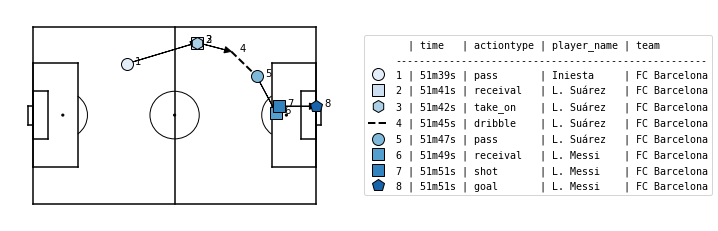

In [13]:
#select a goal to plot
import matplotsoccer

for shot in list(atomic_actions[(atomic_actions.type_name == "goal")][2:3].index):
    a = atomic_actions[shot-7:shot+1].copy()

    a["start_x"] = a.x
    a["start_y"] = a.y
    a["end_x"] = a.x + a.dx
    a["end_y"] = a.y + a.dy

    g = game.iloc[0]
    minute = int((a.period_id.values[0] - 1) * 45 + a.time_seconds.values[0] // 60)
    game_info = f"{g.game_date}, {g.home_team_name} - {g.away_team_name} : {g.home_score}-{g.away_score} , {a[-1:].player_name.values[0]} {minute + 1}'"
    print(game_info)

    def nice_time(row):
        minute = int((row.period_id-1) * 45 + row.time_seconds // 60)
        second = int(row.time_seconds % 60)
        return f"{minute}m{second}s"

    a["nice_time"] = a.apply(nice_time,axis=1)
    labels = a[["nice_time", "type_name", "player_name", "team_name"]]

    matplotsoccer.actions(
        location=a[["start_x", "start_y", "end_x", "end_y"]],
        action_type=a.type_name,
        team= a.team_name,
        label=labels,
        labeltitle=["time", "actiontype", "player_name", "team"],
        zoom=False,
        figsize=6
    )

## Compute features and labels

In [14]:
features_h5 = os.path.join(datafolder, "atomic_features.h5")
labels_h5 = os.path.join(datafolder, "atomic_labels.h5")

In [15]:
games = pd.HDFStore(spadl_h5)['games']
print("nb of games:", len(games))

nb of games: 380


In [18]:
#Example of final framework
print('Features')
display( pd.HDFStore(features_h5)["game_2565907"].head()) #With lags -1,-2.
print('Labels')
display(pd.HDFStore(labels_h5)["game_2565907"].head())

Features


,type_id_a0,type_id_a1,type_id_a2,type_pass_a0,type_cross_a0,type_throw_in_a0,type_freekick_crossed_a0,type_freekick_short_a0,type_corner_crossed_a0,type_corner_short_a0,...,time_seconds_a0,time_seconds_overall_a0,period_id_a1,time_seconds_a1,time_seconds_overall_a1,period_id_a2,time_seconds_a2,time_seconds_overall_a2,time_delta_1,time_delta_2
0,0,0,0,True,False,False,False,False,False,False,...,3.274992,3.274992,1,3.274992,3.274992,1,3.274992,3.274992,0.000000,0.000000
1,23,0,0,False,False,False,False,False,False,False,...,4.192094,4.192094,1,3.274992,3.274992,1,3.274992,3.274992,0.917102,0.917102
2,0,23,0,True,False,False,False,False,False,False,...,5.109197,5.109197,1,4.192094,4.192094,1,3.274992,3.274992,0.917102,1.834205
3,23,0,23,False,False,False,False,False,False,False,...,6.109578,6.109578,1,5.109197,5.109197,1,4.192094,4.192094,1.000381,1.917483
4,0,23,0,True,False,False,False,False,False,False,...,7.109958,7.109958,1,6.109578,6.109578,1,5.109197,5.109197,1.000381,2.000761


Labels


,scores,concedes,goal
0,False,False,False
1,False,False,False
2,False,False,False
3,False,False,False
4,False,False,False


# Predictions

In [19]:
predictions_h5 = os.path.join(datafolder, "atomic-predictions-one-action.h5")

In [20]:
# 1. Select feature set X
xfns = [
    fs.actiontype_onehot,
    fs.bodypart_onehot,
    fs.goalscore,
    fs.location,
    fs.movement_polar,
    fs.polar,
    fs.direction,
    fs.team,
    fs.time,
    fs.time_delta
]
nb_prev_actions = 3

Xcols = fs.feature_column_names(xfns, nb_prev_actions)

def getXY(games, Xcols):
    # generate the columns of the selected feature
    X = []
    for game_id in tqdm.tqdm(games.game_id, desc="Selecting features"):
        Xi = pd.HDFStore(features_h5) [f"game_{game_id}"]
        X.append(Xi[Xcols])
    X = pd.concat(X).reset_index(drop=True)

    # 2. Select label Y
    Ycols = ["scores", "concedes"]
    Y = []
    for game_id in tqdm.tqdm(games.game_id, desc="Selecting label"):
        Yi = pd.HDFStore(labels_h5)[f"game_{game_id}"]
        Y.append(Yi[Ycols])
    Y = pd.concat(Y).reset_index(drop=True)
    return X, Y

In [21]:
# load model 
model = pickle.load(open('trained_model.sav', 'rb'))

In [22]:
#Prediction for all games
gamesX, gamesY = getXY(games,Xcols)
Y_hat = pd.DataFrame()
for col in gamesY.columns:
    Y_hat[col] = [p[1] for p in model[col].predict_proba(gamesX)]

Selecting label: 100%|██████████| 380/380 [00:03<00:00, 99.87it/s] 


In [23]:
# get rows with game id per action
A = []
for game_id in tqdm.tqdm(games.game_id, "Loading actions of each game"):
    Ai = pd.HDFStore(spadl_h5) [f"actions/game_{game_id}"]
    A.append(Ai[["game_id"]])
A = pd.concat(A)
A = A.reset_index(drop=True)

# concatenate action game id rows with predictions and save per game
grouped_predictions = pd.concat([A, Y_hat], axis=1).groupby("game_id")
for k,df in tqdm.tqdm(grouped_predictions, desc="Saving predictions per game"):
    df = df.reset_index(drop=True)
    df[Y_hat.columns].to_hdf(predictions_h5, f"game_{int(k)}")

Saving predictions per game: 100%|██████████| 380/380 [00:09<00:00, 40.51it/s]


## VAEP

In [24]:
with pd.HDFStore(spadl_h5) as spadlstore:
    games = (
        spadlstore["games"]
        .merge(spadlstore["competitions"], how='left')
        .merge(spadlstore["teams"].add_prefix('home_'), how='left')
        .merge(spadlstore["teams"].add_prefix('away_'), how='left'))
    players = spadlstore["players"]
    teams = spadlstore["teams"]
print("nb of games:", len(games))

nb of games: 380


In [25]:
A = []
for game in tqdm.tqdm(list(games.itertuples()), desc="Loading actions"):
    actions = pd.HDFStore(spadl_h5) [f"actions/game_{game.game_id}"]
    actions = (
        atomicspadl.add_names(actions)
        .merge(players, how="left")
        .merge(teams, how="left",)
        .sort_values(["game_id", "period_id", "action_id"])
        .reset_index(drop=True)
    )
    preds = pd.HDFStore(predictions_h5) [f"game_{game.game_id}"]
    values = vaepformula.value(actions, preds.scores, preds.concedes)
    A.append(pd.concat([actions, preds, values], axis=1))
A = pd.concat(A).sort_values(["game_id", "period_id", "time_seconds"]).reset_index(drop=True)
A.columns

Loading actions: 100%|██████████| 380/380 [00:26<00:00, 14.08it/s]


Index(['game_id', 'original_event_id', 'action_id', 'period_id',
       'time_seconds', 'team_id', 'player_id', 'x', 'y', 'dx', 'dy', 'type_id',
       'bodypart_id', 'type_name', 'bodypart_name', 'player_name', 'nickname',
       'team_name_short', 'team_name', 'scores', 'concedes', 'offensive_value',
       'defensive_value', 'vaep_value'],
      dtype='object')

In [27]:
#Retrieve roles for each player
df_players = pd.read_json('/Users/leonardoyang/Desktop/Tesi/Wyscout/raw/players.json')
df_players = df_players[['wyId','shortName','role','currentTeamId']]
Role = []
for i in range(len(df_players)):
    Role.append(df_players['role'][i]['name'])

df_players['Role'] = Role
df_players.drop('role', axis = 1,inplace = True)

A["count"] = 1
# Compute each player's number of actions and total VAEP values
playersR = (
    A[["player_id","vaep_value", "offensive_value", "defensive_value", "count"]]
    .groupby(["player_id"])
    .sum()
    .reset_index()
)
#Add the last team for which the player has played
playersR = playersR.merge(A[["player_id","team_name_short"]].groupby('player_id').tail(1), on = 'player_id')
# Add player name
playersR = playersR.merge(players[["player_id", "nickname", "player_name"]], how="left")
playersR = pd.merge(playersR, df_players, left_on ='player_id', right_on = 'wyId', how = 'left').drop(['wyId','shortName'], axis = 1)
playersR["player_name"] = playersR[["nickname", "player_name"]].apply(lambda x: x[0] if x[0] else x[1],axis=1)
# Show results
playersR = playersR[["player_id", "player_name","Role", "team_name_short","vaep_value", "offensive_value", "defensive_value", "count"]]
playersR.sort_values("vaep_value", ascending=False)[:10]

,player_id,player_name,Role,team_name_short,vaep_value,offensive_value,defensive_value,count
41,3359,L. Messi,Forward,Barcelona,48.167136,47.876719,0.290417,4947
241,7972,L. Suárez,Forward,Barcelona,37.018932,36.013478,1.005455,2850
26,3322,Cristiano Ronaldo,Forward,Real Madrid,30.994976,30.543175,0.451801,2182
135,3840,Iago Aspas,Forward,Celta de Vigo,27.480997,26.420945,1.060052,3229
108,3682,A. Griezmann,Forward,Atl\u00e9tico Madrid,24.155244,22.372832,1.782412,2549
522,395636,Maxi Gómez,Forward,Celta de Vigo,23.873090,22.809967,1.063123,1689
213,5400,Gerard Moreno,Forward,Espanyol,23.725037,22.629167,1.095871,3153
502,355599,Mikel Oyarzabal,Midfielder,Real Sociedad,22.511928,20.525146,1.986783,2592
322,70129,Rodrigo,Forward,Valencia,22.424489,21.662118,0.762371,2459
19,3299,Fernando Pacheco,Goalkeeper,Deportivo Alav\u00e9s,21.627831,2.612235,19.015596,1712


In [28]:
# Normalize for minutes played
pg = pd.HDFStore(spadl_h5) ["player_games"]
pg = pg[pg.game_id.isin(games.game_id)]
mp = pg[["player_id", "minutes_played"]].groupby("player_id").sum().reset_index()

stats = playersR.merge(mp)
stats.rename(columns={'team_name_short':'Team'}, inplace = True)
stats["vaep_rating"] = stats.vaep_value * 90 / stats.minutes_played
stats["offensive_rating"] = stats.offensive_value * 90 / stats.minutes_played
stats["defensive_rating"] = stats.defensive_value * 90 / stats.minutes_played

In [29]:
#filename = 'players_spa.sav'
#pickle.dump(stats, open(filename, 'wb'))
stats = pickle.load(open('players_spa.sav', 'rb'))

In [30]:
stats = stats[stats.minutes_played > 1710] # at least 19 full games played
stats.sort_values("vaep_rating",ascending=False)[:10]

,player_id,player_name,Role,Team,vaep_value,offensive_value,defensive_value,count,minutes_played,vaep_rating,offensive_rating,defensive_rating
40,3359,L. Messi,Forward,Barcelona,48.167136,47.876719,0.290417,4947,3127,1.386326,1.377968,0.008359
25,3322,Cristiano Ronaldo,Forward,Real Madrid,30.994976,30.543175,0.451801,2182,2382,1.171095,1.154024,0.017071
240,7972,L. Suárez,Forward,Barcelona,37.018932,36.013478,1.005455,2850,3015,1.105043,1.075029,0.030014
243,8278,G. Bale,Forward,Real Madrid,19.509810,19.334226,0.175584,2047,1872,0.937972,0.929530,0.008442
107,3682,A. Griezmann,Forward,Atl\u00e9tico Madrid,24.155244,22.372832,1.782412,2549,2606,0.834218,0.772661,0.061557
134,3840,Iago Aspas,Forward,Celta de Vigo,27.480997,26.420945,1.060052,3229,3056,0.809323,0.778104,0.031219
321,70129,Rodrigo,Forward,Valencia,22.424489,21.662118,0.762371,2459,2785,0.724669,0.700033,0.024637
501,355599,Mikel Oyarzabal,Midfielder,Real Sociedad,22.511928,20.525146,1.986783,2592,2877,0.704231,0.642080,0.062152
84,3563,Isco,Midfielder,Real Madrid,14.011722,13.082495,0.929227,3699,1839,0.685729,0.640253,0.045476
521,395636,Maxi Gómez,Forward,Celta de Vigo,23.873090,22.809967,1.063123,1689,3177,0.676291,0.646175,0.030117


In [31]:
stats[stats.Role == "Forward"].sort_values('vaep_rating', ascending = False)[:10].reset_index(drop = True)[['player_name','Role','Team','vaep_rating']]

,player_name,Role,Team,vaep_rating
0,L. Messi,Forward,Barcelona,1.386326
1,Cristiano Ronaldo,Forward,Real Madrid,1.171095
2,L. Suárez,Forward,Barcelona,1.105043
3,G. Bale,Forward,Real Madrid,0.937972
4,A. Griezmann,Forward,Atl\u00e9tico Madrid,0.834218
5,Iago Aspas,Forward,Celta de Vigo,0.809323
6,Rodrigo,Forward,Valencia,0.724669
7,Maxi Gómez,Forward,Celta de Vigo,0.676291
8,C. Bacca,Forward,Villarreal,0.668022
9,S. Zaza,Forward,Valencia,0.663010


In [37]:
stats[stats.Role == "Defender"].sort_values('vaep_rating', ascending = False)[:10].reset_index(drop = True)[['player_name','Role','Team','vaep_rating']]

,player_name,Role,Team,vaep_rating
0,Marcelo,Defender,Real Madrid,0.459738
1,Luisinho,Defender,Deportivo La Coru\u00f1a,0.379362
2,Sergio Ramos,Defender,Real Madrid,0.350879
3,Filipe Luis,Defender,Atl\u00e9tico Madrid,0.341739
4,Juanfran,Defender,Deportivo La Coru\u00f1a,0.334072
5,Íñigo Martínez,Defender,Athletic Club,0.329210
6,Juan Cala,Defender,Getafe,0.309191
7,Mario,Defender,Villarreal,0.299635
8,Piqué,Defender,Barcelona,0.289747
9,Raúl Navas,Defender,Real Sociedad,0.285826


# Salary

In [38]:
spa = pd.read_excel('/Users/leonardoyang/Desktop/Tesi/Data/la-liga/2017-2018/all_la-liga_2017-2018.xlsx')
spa = spa[spa['Annual Gross(IN EUR)']>0]
spa = spa.drop_duplicates(subset=["Player"], keep='last')
spa.drop('Unnamed: 0', axis = 1, inplace = True)
spa['Name'] = [spa['Player'][i-1:i].values[0].split()[0] for i in range(1,len(spa.Player)+1)]
spa['Surname'] = [spa['Player'][i-1:i].values[0].split()[-1] for i in range(1,len(spa.Player)+1)]

In [39]:
#Retrieve player full name and surname
players['Name'] =[players['player_name'][i-1:i].values[0].split()[0] for i in range(1,len(players.player_name)+1)]
players['Surname'] =[players['player_name'][i-1:i].values[0].split()[-1] for i in range(1,len(players.player_name)+1)]
giocatori = stats.merge(players, on = 'player_id').drop(['nickname'], axis = 1)
#giocatori = giocatori[giocatori['minutes_played']>1400]

#Merge players' stats and salary based on surname,name. Those players not matched due to language barriers were manually added by including their WyID in the salary data.
df = pd.merge(giocatori,spa, on = ['Name','Surname'], how = 'left').sort_values('Annual Gross(IN EUR)', ascending = False).rename(columns={'Annual Gross(IN EUR)':'Salary'})
df = df[['player_id','Player','Age','Role_x','Team_x','vaep_value','offensive_value','defensive_value','count','minutes_played','vaep_rating','Salary']]

missing = pd.merge(df,spa, left_on = 'player_id', right_on = 'ID') #Missing players
missing = missing[['player_id','Player_y','Age_y','Role_x','Team_x','vaep_value','offensive_value','defensive_value','count','minutes_played','vaep_rating','Annual Gross(IN EUR)']]
missing.rename(columns={'Player_y':'Player','Age_y':'Age','Annual Gross(IN EUR)':'Salary'}, inplace = True)

df = pd.concat([df,missing]).rename(columns = {'Role_x':'Role','Team_x':'Team'}).reset_index(drop=True)
df = df.dropna().drop_duplicates().drop('player_id', axis = 1)

#Create VAEP/Salary
df['vaep/salary'] = df['vaep_value']*10**4/ df['Salary']

display(df[(df['Role']=='Defender')].sort_values('vaep/salary',ascending = False).groupby('Role').mean())
display(df[(df['Role']=='Forward')].sort_values('vaep/salary',ascending = False).groupby('Role').mean())

,Age,vaep_value,offensive_value,defensive_value,count,minutes_played,vaep_rating,Salary,vaep/salary
Role,,,,,,,,,
Defender,26.315789,5.674532,3.179091,2.495442,3160.210526,2487.596491,0.20346,2.879158e+06,0.053158


,Age,vaep_value,offensive_value,defensive_value,count,minutes_played,vaep_rating,Salary,vaep/salary
Role,,,,,,,,,
Forward,27.137931,16.482594,15.723651,0.758943,2035.37931,2394.0,0.596752,7.452931e+06,0.057331


In [40]:
df.groupby('Role').agg(['mean']).iloc[:2][['vaep_value','Salary','vaep/salary']].round(4)

,vaep_value,Salary,vaep/salary
,mean,mean,mean
Role,,,
Defender,5.6745,2.879158e+06,0.0532
Forward,16.4826,7.452931e+06,0.0573


### TOP 11

In [41]:
gk = df[df['Role']=='Goalkeeper'].sort_values('vaep/salary',ascending = False)[:5]
dif = df[df['Role']=='Defender'].sort_values('vaep/salary',ascending = False)[:5]
cen = df[df['Role']=='Midfielder'].sort_values('vaep/salary',ascending = False)[:5]
att = df[df['Role']=='Forward'].sort_values('vaep/salary',ascending = False)[:5]

In [42]:
top_11 = gk.append(dif).append(cen).append(att)
#top_11['Salary'] = top_11['Salary'].astype(int).map('{:,}'.format)
top_11 = top_11[['Player','Age','Role','Team','vaep_rating','minutes_played','vaep_value','Salary','vaep/salary']]
top_11.loc[:,'vaep_rating':] = top_11.loc[:,'vaep_rating':].round(4)
order = ['Goalkeeper','Defender','Midfielder','Forward']
top_11["Role"] = pd.Categorical(top_11["Role"], categories=order, ordered=True)
n = {'Goalkeeper':1, 'Defender':4,'Midfielder':3, 'Forward':3}
top_11 = top_11.groupby('Role').apply(lambda x: x.sort_values("vaep_rating", ascending=False)).drop('Role', axis = 1).reset_index()
top_11 = top_11.groupby('Role').apply(lambda x: x.head(n[x.name])).drop('level_1', axis = 1).reset_index(drop=True)
top_11.index =top_11.index +1
top_11[['Player','Age','Role','Team','vaep_rating','vaep_value','Salary','vaep/salary']]

,Player,Age,Role,Team,vaep_rating,vaep_value,Salary,vaep/salary
1,Leandro Chichizola,27.0,Goalkeeper,Las Palmas,0.6336,17.8813,247000.0,0.7239
2,Luisinho,32.0,Defender,Deportivo La Coru\u00f1a,0.3794,11.5284,704000.0,0.1638
3,Clément Lenglet,22.0,Defender,Sevilla,0.2770,9.6979,593000.0,0.1635
4,Damián Suárez,29.0,Defender,Getafe,0.2715,9.1511,529000.0,0.1730
5,Pablo Maffeo,19.0,Defender,Girona,0.1575,4.8055,289000.0,0.1663
6,Mikel Oyarzabal,20.0,Midfielder,Real Sociedad,0.7042,22.5119,2242000.0,0.1004
7,Portu,25.0,Midfielder,Girona,0.4737,16.3000,826000.0,0.1973
8,Joan Jordán,22.0,Midfielder,Eibar,0.4319,12.1424,675000.0,0.1799
9,Cristhian Stuani,30.0,Forward,Girona,0.6627,20.6314,1849000.0,0.1116
10,Gerard Moreno,25.0,Forward,Espanyol,0.5998,23.7250,2257000.0,0.1051


In [43]:
print("Average salary per Team(~starting 11)): ",('{:,}'.format(int(df.groupby('Team').sum()['Salary'].mean()))),"€")
print("Median salary per Team(~starting 11)): ",('{:,}'.format(int(df.groupby('Team').sum()['Salary'].median()))),"€")
print("Salary per Top_11: " + ('{:,}'.format(int(top_11.Salary.sum()))+ "€"))

Average salary per Team(~starting 11)):  30,993,750 €
Median salary per Team(~starting 11)):  14,374,000 €
Salary per Top_11: 10,806,000€
